In [4]:
import pandas as pd

df = pd.read_csv("data/german.data-numeric", sep=r"\s+", header=None, engine="python")

n_cols = df.shape[1]
if n_cols < 2:
    raise ValueError(f"Unexpected column count: {n_cols}")

if n_cols == 21:
    # Classic: 20 features + target
    cols = [
        "checking_status", "duration_months", "credit_history", "purpose", "credit_amount",
        "savings_status", "employment_since", "installment_rate_pct", "personal_status_sex", "other_debtors",
        "residence_since", "property_magnitude", "age_years", "other_installment_plans", "housing",
        "number_existing_credits", "job", "people_liable_maintenance", "telephone", "foreign_worker",
        "target"
    ]
elif n_cols == 25:
    # UCI numeric (Statlog) variant: 24 features + target
    # The extra 4 are engineered indicator variables in that numeric release.
    cols = [
        "checking_status", "duration_months", "credit_history", "purpose", "credit_amount",
        "savings_status", "employment_since", "installment_rate_pct", "personal_status_sex", "other_debtors",
        "residence_since", "property_magnitude", "age_years", "other_installment_plans", "housing",
        "number_existing_credits", "job", "people_liable_maintenance", "telephone", "foreign_worker",
        "extra_indicator_1", "extra_indicator_2", "extra_indicator_3", "extra_indicator_4",
        "target"
    ]
# else:
#     # Fallback: name generically
#     cols = [f"feature_{i}" for i in range(1, n_cols)] + ["target"]


df.columns = cols

# Map target: 1 = good, 2 = bad  -> 0 = good, 1 = bad
df["target"] = df["target"].map({1: 0, 2: 1})

print("Shape:", df.shape)
print("First rows:")
display(df.head())

print("\nClass balance (0=good, 1=bad):")
print(df["target"].value_counts(normalize=True).round(3))
print("\nMissing values per column (top 10 shown):")
print(df.isna().sum().sort_values(ascending=False).head(10))

Shape: (1000, 25)
First rows:


,checking_status,duration_months,credit_history,purpose,credit_amount,savings_status,employment_since,installment_rate_pct,personal_status_sex,other_debtors,...,number_existing_credits,job,people_liable_maintenance,telephone,foreign_worker,extra_indicator_1,extra_indicator_2,extra_indicator_3,extra_indicator_4,target
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,0
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,1
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,0
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,0
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,1



Class balance (0=good, 1=bad):
target
0    0.7
1    0.3
Name: proportion, dtype: float64

Missing values per column (top 10 shown):
checking_status              0
other_installment_plans      0
extra_indicator_4            0
extra_indicator_3            0
extra_indicator_2            0
extra_indicator_1            0
foreign_worker               0
telephone                    0
people_liable_maintenance    0
job                          0
dtype: int64


In [5]:
for c in [col for col in df.columns if col.startswith("extra_indicator_")]:
    print(c)
    print(df[c].value_counts().sort_index(), "\n")

extra_indicator_1
extra_indicator_1
0    287
1    713
Name: count, dtype: int64 

extra_indicator_2
extra_indicator_2
0    978
1     22
Name: count, dtype: int64 

extra_indicator_3
extra_indicator_3
0    800
1    200
Name: count, dtype: int64 

extra_indicator_4
extra_indicator_4
0    370
1    630
Name: count, dtype: int64 



In [6]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [8]:
print("Shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isna().sum())
print("\nTarget distribution:\n", df['target'].value_counts(normalize=True))

Shape: (1000, 25)

Data types:
 checking_status              int64
duration_months              int64
credit_history               int64
purpose                      int64
credit_amount                int64
savings_status               int64
employment_since             int64
installment_rate_pct         int64
personal_status_sex          int64
other_debtors                int64
residence_since              int64
property_magnitude           int64
age_years                    int64
other_installment_plans      int64
housing                      int64
number_existing_credits      int64
job                          int64
people_liable_maintenance    int64
telephone                    int64
foreign_worker               int64
extra_indicator_1            int64
extra_indicator_2            int64
extra_indicator_3            int64
extra_indicator_4            int64
target                       int64
dtype: object

Missing values:
 checking_status              0
duration_months              0

In [9]:
import numpy as np

numeric_cols = ["duration_months", "credit_amount", "age_years"]

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"{col}: {outliers} outliers (bounds: {lower:.1f}, {upper:.1f})")

duration_months: 70 outliers (bounds: -6.0, 42.0)
credit_amount: 0 outliers (bounds: -2.0, 6.0)
age_years: 155 outliers (bounds: 1.0, 1.0)


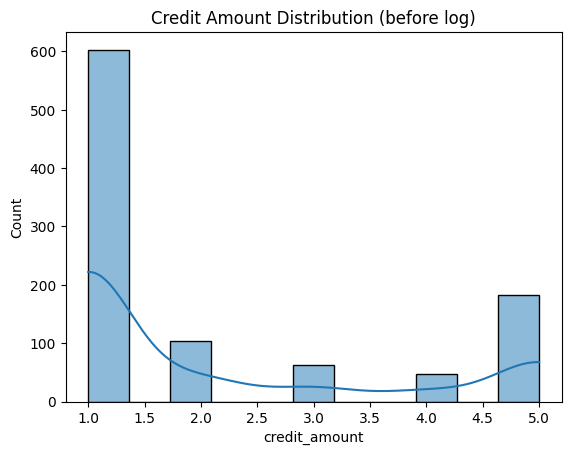

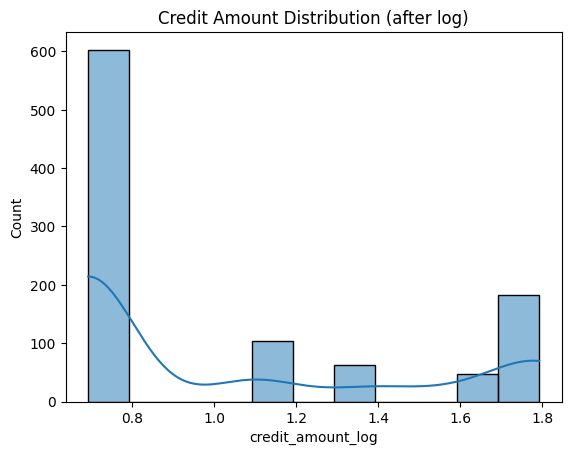

In [10]:
sns.histplot(df["credit_amount"], kde=True)
plt.title("Credit Amount Distribution (before log)")
plt.show()

# Apply log-transform
df["credit_amount_log"] = np.log1p(df["credit_amount"])
sns.histplot(df["credit_amount_log"], kde=True)
plt.title("Credit Amount Distribution (after log)")
plt.show()

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[["duration_scaled", "credit_amount_scaled", "age_scaled"]] = scaler.fit_transform(
    df[["duration_months", "credit_amount_log", "age_years"]]
)

In [13]:
categorical_cols = [
    "checking_status", "credit_history", "purpose", "savings_status", 
    "employment_since", "personal_status_sex", "other_debtors", 
    "property_magnitude", "other_installment_plans", "housing", 
    "job", "telephone", "foreign_worker",
    "extra_indicator_1", "extra_indicator_2", 
    "extra_indicator_3", "extra_indicator_4"
]

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print("Original shape:", df.shape)
print("New shape after encoding:", df_encoded.shape)

Original shape: (1000, 29)
New shape after encoding: (1000, 217)


Outliter Detection and Capping

In [14]:
def cap_outliers(df, cols):
    df_copy = df.copy()
    for col in cols:
        Q1 = df_copy[col].quantile(0.25)
        Q3 = df_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_copy[col] = np.where(df_copy[col] < lower, lower,
                                np.where(df_copy[col] > upper, upper, df_copy[col]))
    return df_copy

numeric_cols = ["duration_months", "credit_amount", "age_years"]
df = cap_outliers(df, numeric_cols)

FEATURE TRANSFORMATION

In [15]:
df["credit_amount_log"] = np.log1p(df["credit_amount"])

In [16]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[["duration_months", "credit_amount_log", "age_years"]])
df[["duration_scaled", "credit_amount_scaled", "age_scaled"]] = scaled_features

In [17]:
categorical_cols = [
    "checking_status", "credit_history", "purpose", "savings_status", 
    "employment_since", "personal_status_sex", "other_debtors", 
    "property_magnitude", "other_installment_plans", "housing", 
    "job", "telephone", "foreign_worker",
    "extra_indicator_1", "extra_indicator_2", 
    "extra_indicator_3", "extra_indicator_4"
]

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [18]:
df_encoded["credit_to_duration"] = df["credit_amount"] / (df["duration_months"] + 1e-6)
df_encoded["installment_burden"] = df["installment_rate_pct"] / (df["duration_months"] + 1e-6)

df_encoded["age_bucket"] = pd.cut(
    df["age_years"],
    bins=[18, 30, 45, 60, 100],
    labels=["young", "mid_age", "mature", "senior"]
)
df_encoded = pd.get_dummies(df_encoded, columns=["age_bucket"], drop_first=True)

In [19]:
print("Original shape:", df.shape)
print("Encoded shape:", df_encoded.shape)
print("\nTarget distribution:\n", df_encoded["target"].value_counts(normalize=True))

print("\nSample of engineered features (first 5 rows):")
print(df_encoded[["credit_amount", "duration_months", "credit_to_duration",
                  "installment_burden", "age_years"]].head())

Original shape: (1000, 29)
Encoded shape: (1000, 222)

Target distribution:
 target
0    0.7
1    0.3
Name: proportion, dtype: float64

Sample of engineered features (first 5 rows):
   credit_amount  duration_months  credit_to_duration  installment_burden  \
0            5.0              6.0            0.833333            0.666667   
1            1.0             42.0            0.023810            0.047619   
2            1.0             12.0            0.083333            0.250000   
3            1.0             42.0            0.023810            0.095238   
4            1.0             24.0            0.041667            0.166667   

   age_years  
0        1.0  
1        1.0  
2        1.0  
3        1.0  
4        1.0  


In [20]:
X = df_encoded.drop("target", axis=1)
y = df_encoded["target"]

print("\nFinal feature count:", X.shape[1])


Final feature count: 221
